In [1]:
# import os
# 
# os.environ['TF_CUDA_PATHS'] = '/usr/lib/cuda,/usr/lib/cuda/nvvm'
# os.environ['LD_LIBRARY_PATH'] = '/usr/lib/cuda/lib64:/usr/lib/cuda/nvvm:' + os.environ.get('LD_LIBRARY_PATH', '')
# 
# import tensorflow as tf


In [2]:
import os

import keras.metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import albumentations
from utils import *
import skimage
# Force CPU usage
# try:
#     # Disable all GPUs
#     tf.config.set_visible_devices([], 'GPU')
#     logical_devices = tf.config.list_logical_devices('GPU')
#     print(f"Logical GPUs: {logical_devices}")
# except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Eager Execution Enabled:", tf.executing_eagerly())

2025-08-06 09:19:20.575464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 09:19:20.783270: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 09:19:21.885475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-08-06 09:19:21.885571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Num GPUs Available:  1
Eager Execution Enabled: True


2025-08-06 09:19:24.581427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-06 09:19:24.716082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-06 09:19:24.716505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
model_input_shape = (224, 224)
model_feature_map_shape = tuple(np.asarray(model_input_shape) // 32)
no_classes = 20
alpha_loss, beta_loss = 1.0, 0.0  # Class, SAL
model_name = "model_softmax_part_class"
full_dataset = False
schedule = False
schedule_change = 0.01
pool_layer = "softmax"  # "softmax" "class_softmax" "GeM" "mean" "max"
load_model = False
train = True
combined_loss_li = []
cce_loss_li = []
sal_loss_li = []
train_size = 0.9
use_max = False
learning_rate = (0.00005 * 0.5) if full_dataset else 0.00005 * 0.5
beta_lr_factor = 3.0 if full_dataset else 100.0
beta_start_val = 0.0
epochs = 20 if full_dataset else 75
loss = "BCE" # "BCE" "CCE"
# base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet")
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet")
predictions_hist_train = []
predictions_hist_test = []
no_images = len(os.listdir("../../pascal/output/boxes")) if full_dataset else len(os.listdir("../../dataset/seg"))

2025-08-06 09:19:24.743815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 09:19:24.744827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-06 09:19:24.745275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-06 09:19:24.745609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
# Example Usage
# Load a backbone model without the top dense layers
# base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

# Modify the model for 10 classes
model = create_model_with_spatial_scores(base_model, no_classes + 1, use_max, pool_layer, start_value=beta_start_val)

# Print model summary
model.summary()
if pool_layer == "softmax":
    print(f"Softmax weight = {float(model.trainable_variables[-1])}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

(331, 500, 3)
(331, 500)


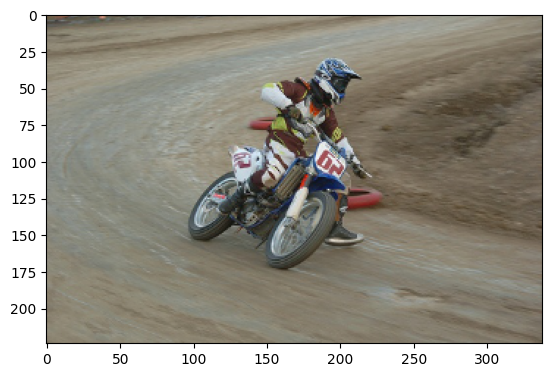

(224, 338, 3)


In [5]:
# img_path = '../imgs/cb1000r.jpg'
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.load("../../dataset/img/train_5.npy")
seg = np.load("../../dataset/seg/train_5.npy")
print(img.shape)
print(seg.shape)
# img = 255 - img

img_smallest_dim = np.argmin(img.shape[:2])
ratio = model_input_shape[img_smallest_dim] / img.shape[img_smallest_dim]
new_size = (ratio * np.asarray(img.shape[:2])).astype(int)
img = cv2.resize(img, new_size[::-1])
seg = cv2.resize(seg, new_size[::-1], interpolation=cv2.INTER_NEAREST)

plt.imshow(img)
plt.show()
print(img.shape)

# img = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img, axis=0).astype('float32') / 255.0

In [6]:
img_array.shape

(1, 224, 338, 3)

In [7]:
spatial_scores, class_scores = model.predict(img_array)

2025-08-06 09:19:29.259043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


1/1 [==============================] - 3s 3s/step


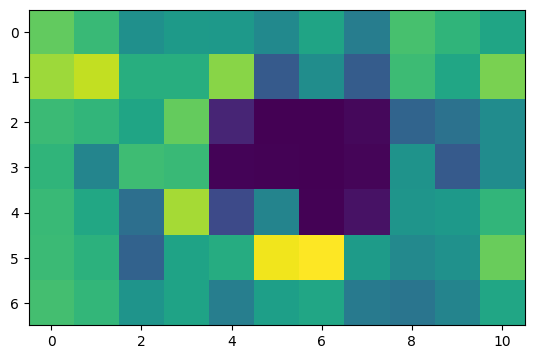

In [8]:
plt.imshow(spatial_scores[0][:,:,1])
plt.show()

In [9]:
spatial_scores.shape

(1, 7, 11, 21)

In [10]:
# img_transformer = TransformationManager(crop_fraction=0.8, horizontal_flip=True)


In [11]:
transform = albumentations.Compose([
    # albumentations.RandomCrop(width=224, height=224),
    albumentations.RandomCrop(width=model_input_shape[0], height=model_input_shape[1]),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
])

In [12]:
transform_seed = albumentations.Compose([
    # albumentations.RandomCrop(width=224, height=224),
    albumentations.RandomCrop(width=model_input_shape[0], height=model_input_shape[1]),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
], seed=1)

In [13]:
img.shape

(224, 338, 3)

In [14]:
seg.shape

(224, 338)

In [15]:
to_categorical(seg).shape

(224, 338, 21)

In [16]:
transformed = transform(image=img, mask=to_categorical(seg).astype(int))


In [17]:
# transformed_img = img_transformer.apply_transformations(img, 3).numpy()

In [18]:
transformed["image"].dtype

dtype('uint8')

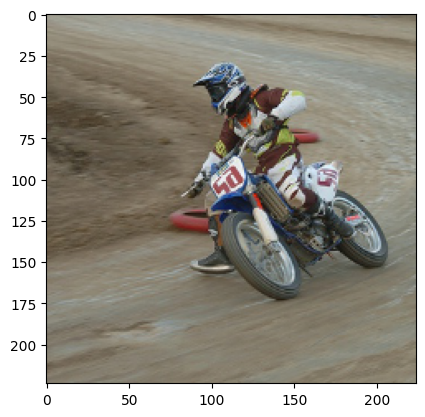

In [19]:
transform_seed.set_random_seed(43)
transformed = transform_seed(image=img, mask=to_categorical(seg).astype(int))
plt.imshow(transformed["image"])
plt.show()
transformed_img_arr = np.expand_dims(transformed["image"], axis=0).astype('float32') / 255.0
# heatmap = model.predict([transformed_img_arr])[0][0]
# img_transformer.reverse_transformations(transformed_img, 0)

In [20]:
def draw_mask(image, mask_generated):
    mask_generated = np.max(transformed["mask"], axis=-1)
    mask_generated = np.expand_dims(mask_generated, axis=-1)
    mask_generated = np.concatenate((mask_generated, np.zeros(mask_generated.shape), np.zeros(mask_generated.shape)), axis=-1)
    masked_image = image.copy()
    
    masked_image = np.where(mask_generated.astype(int),
                          np.array([0,255,0], dtype='uint8'),
                          masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    
    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

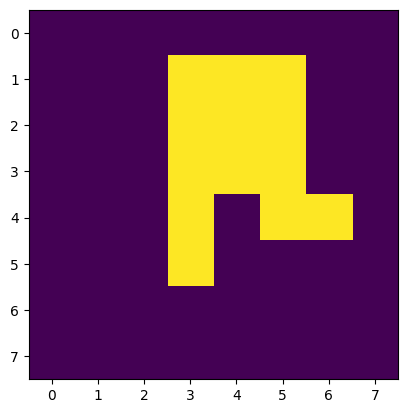

In [21]:
resized_mask = cv2.resize(transformed["mask"].astype(int), (10,10), interpolation=cv2.INTER_NEAREST)
resized_mask_li = []
for idx in range(transformed["mask"].shape[-1]):
    single_mask = transformed["mask"][:,:, idx]
    single_mask = cv2.dilate(single_mask.astype(float), np.ones((11,11)), iterations=2)
    resized_single = cv2.resize(single_mask.astype(float), (8,8), interpolation=cv2.INTER_LINEAR)
    # if idx == 5:
    #     plt.imshow(resized_single)
    #     plt.show()
    # resized_single = cv2.resize(resized_single, transformed["image"].shape[:2], interpolation=cv2.INTER_NEAREST)
    resized_single = np.round(resized_single)
    resized_single = np.expand_dims(resized_single, axis=-1)
    
    resized_mask_li.append(resized_single.astype(int))
resized_mask = np.concatenate(resized_mask_li, axis=-1)
plt.imshow(resized_mask[:,:,15])
plt.show()
# np.unique(to_ordinal(resized_mask))

# resized_mask = cv2.resize(resized_mask, transformed["image"].shape[:2], interpolation=cv2.INTER_NEAREST)

In [22]:
def resize_to_input(seg_mask):
    un_resized_li = []
    for dim in range(seg_mask.shape[-1]):
        un_resized_li.append(np.expand_dims(cv2.resize(seg_mask[:,:,dim].astype(float), model_input_shape[:2], interpolation=cv2.INTER_LINEAR), axis=-1))
    un_resized = np.concatenate(un_resized_li, axis=-1)
    return un_resized

In [23]:
# un_resized = resize_to_input(resized_mask)
# un_resized = resize_to_input_tf(np.asarray([resized_mask, resized_mask]))
# print(un_resized.shape)
# plt.imshow(un_resized[0,:,:,15])
# plt.show()

In [24]:
# m_iou = tf.keras.metrics.MeanIoU(num_classes=no_classes + 1)
# m_iou.update_state(to_ordinal(resized_mask), to_ordinal(seg[0]))
# m_iou.result()

In [25]:
# heatmap_0 = heatmap[:,:,0]
# heatmap_0 = np.expand_dims(heatmap_0, -1)
# heatmap_0 = np.repeat(heatmap_0, 3, 2)
# heatmap_0.shape

In [26]:
# plt.imshow(img_transformer.reverse_transformations(heatmap_0, 3))
# plt.show()

In [27]:
classes_df = pd.read_csv("../../dataset/train_set.csv")

In [28]:
classes_mat = classes_df.drop(columns=["Id"]).to_numpy()

In [29]:
classes_mat[1].shape

(20,)

In [30]:
def load_image_and_mask_pascal(im_name):
    im_name = im_name.numpy().decode("utf-8")
    img = np.load(f"../../pascal/output/images/{im_name}")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    box = np.load(f"../../pascal/output/boxes/{im_name}")
    seg, classes = seg_from_box(box,img.shape, no_classes)
    return tf.convert_to_tensor(img, dtype=tf.uint8), tf.convert_to_tensor(seg, dtype=tf.uint8), tf.convert_to_tensor(classes, dtype=tf.uint8)

In [31]:
def load_image_and_mask(im_no):
    im_no = int(im_no)
    img = np.load(f"../../dataset/img/train_{im_no}.npy")
    seg = np.load(f"../../dataset/seg/train_{im_no}.npy")
    classes = classes_mat[im_no]
    return tf.convert_to_tensor(img, dtype=tf.uint8), tf.convert_to_tensor(seg, dtype=tf.uint8), tf.convert_to_tensor(classes, dtype=tf.uint8)

In [32]:
def tf_load_image_and_mask(im_no_t):
    if full_dataset:
        image, mask, classes = tf.py_function(
            func=load_image_and_mask_pascal,    # Python function to call
            inp=[im_no_t],                 # Input tensor
            Tout=[tf.uint8, tf.uint8, tf.uint8]  # Output data types
        )
    else:
        image, mask, classes = tf.py_function(
            func=load_image_and_mask,    # Python function to call
            inp=[im_no_t],                 # Input tensor
            Tout=[tf.uint8, tf.uint8, tf.uint8]  # Output data types
        )
    
    # Set static shapes (important for TensorFlow pipelines)
    # image.set_shape([model_input_shape[0], model_input_shape[1], 3])
    # mask.set_shape([model_input_shape[0], model_input_shape[1], 1])
    return image, mask, classes

In [33]:
augment_image_and_mask = make_augement_image_and_mask(transform, model_input_shape)
augment_image_and_mask_seed = make_augement_image_and_mask(transform_seed, model_input_shape, seed=100)

In [34]:
def tf_augment_image_and_mask(image, mask, classes):
    image, mask = tf.py_function(
        func=augment_image_and_mask,    # Python function to call
        inp=[image, mask],                 # Input tensor
        Tout=[tf.float32, tf.uint8]  # Output data types
    )
    # Set static shapes (important for TensorFlow pipelines)
    image.set_shape([model_input_shape[0], model_input_shape[1], 3]) 
    mask.set_shape([model_input_shape[0], model_input_shape[1], no_classes + 1])
    return image, mask, classes

In [35]:
if full_dataset:
    files = os.listdir(f"../../pascal/output/images/")
    files = [file for file in files if os.path.exists(f"../../pascal/output/boxes/{file}")]
    dataset = tf.data.Dataset.from_tensor_slices(np.asarray(files))
else:
    dataset = tf.data.Dataset.from_tensor_slices(np.arange(no_images))  # the number of dataset items I've got

In [36]:
dataset = dataset.map(lambda img_id: tf_load_image_and_mask(img_id), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda image, mask, classes: tf_augment_image_and_mask(image, mask, classes), num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
# dataset = dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [38]:
# for images_batch, masks_batch, classes in dataset.take(1):
#     print(images_batch.shape)
#     print(masks_batch.shape)
#     print(classes)
#     for img, mask, cls in zip(images_batch, masks_batch, classes):
#         print(np.max(img))
#         img = img.numpy()
#         img = img.astype(float) / np.max(img)
#         plt.imshow(img)
#         plt.show()
#         print(np.min(np.max(mask.numpy()[:,:,1:],axis=-1)))
#         plt.imshow(np.max(mask.numpy()[:,:,1:],axis=-1))
#         plt.show()
#         print(np.argmax(cls) + 1)
    

In [39]:
def spatial_consistency_loss(score_map, heatmap, transformation):
    """
    Computes the Spatial Consistency Loss (SCL).
    Args:
        score_map (tf.Tensor): Current spatial score map (F^t_n), shape [batch_size, G, G, num_classes].
        heatmap (tf.Tensor): Running average heatmap (H^{t-1}_n), shape [batch_size, W, W, num_classes].
        transformation (tf.Tensor): Augmentation transformation applied to the input (e.g., crop, flip).
    Returns:
        tf.Tensor: The SCL value.
    """
    # Apply the transformation (e.g., cropping, flipping) to the heatmap
    transformed_heatmap = tf.image.resize(heatmap, score_map.shape[1:3], method='bilinear')
    # Compute the L1 distance
    scl = tf.reduce_mean(tf.abs(score_map - transformed_heatmap))
    return scl

In [40]:
@tf.function
def resize_to_input_tf(seg_masks):
    # Resize masks
    resized_masks = tf.image.resize(
        seg_masks, 
        size=model_input_shape[:2], 
        method=tf.image.ResizeMethod.BILINEAR
    )
    return resized_masks

In [41]:
resize_to_output_tf = make_resize_to_output_tf(model_input_shape, model_feature_map_shape)


In [42]:
def custom_loss_function(alpha=1.0, beta=1.0):
    """
    Combines Spatial Consistency Loss and Categorical Cross-Entropy Loss.
    Args:
        alpha (float): Weight for the CCE loss.
        beta (float): Weight for the SCL loss.
    Returns:
        function: A callable loss function to use during model training.
    """
    # mae = tf.keras.metrics.MeanSquaredError()
    def loss_function(y_true, y_pred, seg_masks, heatmap, test=False):
        """
        Args:
            y_true (tf.Tensor): Ground-truth class labels, shape [batch_size, num_classes].
            y_pred (tf.Tensor): Predicted class probabilities, shape [batch_size, num_classes].
            num_classes: Number of classes
            seg_masks: segmentation masks Shape: (batch, x, y, k)
            heatmap: Attention heatmaps
        Returns:
            tf.Tensor: The combined loss value.
        """
        # Compute categorical cross-entropy loss
        # print("Categorical", y_true.shape, y_pred.shape)
        if loss == "CCE":
            cce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred[:,:])
        elif loss == "BCE":
            cce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred[:,:])
        # heatmap_resized = resize_to_input_tf(heatmap)
        # print(seg_masks[:,:,:,1:].shape)
        seg_masks_resized = resize_to_output_tf(seg_masks, heatmap.shape[1:])
        # print(heatmap.dtype, seg_masks_resized.dtype)
        # print(heatmap.shape, seg_masks_resized.shape)
        # print(seg_masks.numpy())
        # tf.print(heatmap_resized)
        # plt.imshow(to_ordinal(heatmap_resized.numpy()))
        # plt.show()
        # mae_loss = tf.keras.losses.MeanSquaredError()(seg_masks, heatmap_resized)
        # mae_loss = tf.keras.losses.CategoricalCrossentropy()(seg_masks, heatm
        if loss == "CCE":
            mae_loss = tf.keras.losses.CategoricalCrossentropy()(seg_masks_resized[:,:,:,:], heatmap[:,:,:,:])
        elif loss == "BCE":
            mae_loss = tf.keras.losses.BinaryCrossentropy()(seg_masks_resized[:,:,:,:], heatmap[:,:,:,:])
        # print(tf.keras.losses.CategoricalCrossentropy()(seg_masks_resized.numpy(), np.full(seg_masks_resized.shape, 1, dtype=np.float32)))
        # print(tf.keras.losses.CategoricalCrossentropy()(seg_masks_resized.numpy(), np.zeros(seg_masks_resized.shape) + 0.0001))
        # print(seg_masks_resized[5,:,:,15])

        # print(mae_loss, tf.keras.metrics.MeanSquaredError()(seg_masks, heatmap_resized))
        # m_iou.update_state(seg_masks, heatmap_resized)
        
        # # Compute spatial consistency loss
        # scl_loss = spatial_consistency_loss(score_map, heatmap, transformation)
        # if test:
        #     print(cce_loss, y_true.shape, y_pred.shape)
        #     # tf.print(y_pred[:,1:])
        #     tf.print("pred class:", tf.reduce_min(y_pred[:,1:]), tf.reduce_max(y_pred[:,1:]), tf.norm(y_pred[:,1:]))
        #     tf.print("pred seg:", tf.reduce_min(heatmap_resized), tf.reduce_max(heatmap_resized), tf.norm(heatmap_resized))
        # Combine the two losses
        total_loss = alpha * cce_loss + beta * mae_loss
        if test:
            return total_loss, cce_loss, mae_loss
        return total_loss

    return loss_function

In [43]:
# @tf.function
def train_step(model, optimizer, images, seg_maps, labels, loss_fn):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass: predict class probabilities and score maps
        score_map, class_preds = model(images, training=True)

        # Compute the combined loss
        loss = loss_fn(labels, class_preds[:,1:], seg_maps, score_map, test=False)

    # Separate trainable variables
    beta_variables = []
    other_variables = []
    for var in model.trainable_variables:
        if "softmax_pooling" in var.name and "beta" in var.name:
            beta_variables.append(var)
        other_variables.append(var)

    # Backward pass: compute gradients for beta variables
    beta_gradients = tape.gradient(loss, beta_variables)

    # Backward pass: compute gradients for other variables
    other_gradients = tape.gradient(loss, other_variables)

    del tape

    # Apply gradients to beta variables with a higher learning rate
    if beta_gradients:
        beta_optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer.learning_rate * beta_lr_factor)
        beta_optimizer.apply_gradients(zip(beta_gradients, beta_variables))

    # Apply gradients to other variables with the original learning rate
    optimizer.apply_gradients(zip(other_gradients, other_variables))

    return loss

In [44]:
def val_step(model, images, seg_maps, labels, loss_fn):
    score_map, class_preds = model(images, training=False)
    predictions_hist_test[-1] += list(np.dstack((class_preds.numpy()[:,1:], np.asarray(labels))))
    loss = loss_fn(labels, class_preds[:,1:], seg_maps[:,:,:,1:], score_map[:,:,:,1:], test=True)
    return loss

In [45]:
def get_example(im_name, epoch="", save=True):
    img, seg, classes = tf_load_image_and_mask(im_name)
    img, mask = augment_image_and_mask_seed(img, seg)
    spatial_scores, class_scores = model(np.expand_dims(img, axis=0), training=False)
    if save:
        os.makedirs(f"examples/{model_name}", exist_ok=True)
        np.save(f"examples/{model_name}/{epoch}_augmented_{im_name}", img)
        np.save(f"examples/{model_name}/{epoch}_spatial_scores_{im_name}", spatial_scores)
    return img, spatial_scores, epoch, im_name


def save_best_examples(best_examples):
    for img, spatial_scores, epoch, im_name in best_examples:
        os.makedirs(f"examples/{model_name}", exist_ok=True)
        np.save(f"examples/{model_name}/{epoch}_augmented_{im_name}_best", img)
        np.save(f"examples/{model_name}/{epoch}_spatial_scores_{im_name}_best", spatial_scores)

In [46]:
def train_model(model, dataset, epochs, optimizer, alpha, beta, losses=None, train_split=0.8):
    """
    Train the model using the custom train_step function.

    Args:
        model (tf.keras.Model): The neural network model.
        dataset (tf.data.Dataset): Dataset containing input images and labels.
        epochs (int): Number of training epochs.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for training.
        alpha (float): Weight for categorical cross-entropy loss.
        beta (float): Weight for spatial consistency loss.
    """
    if losses is None:
        losses = []
    best_loss = np.inf
    best_class_loss = np.inf
    best_loss_examples = []

    train_data = dataset.take(int(train_split * no_images)).batch(16).prefetch(tf.data.AUTOTUNE)
    test_data = dataset.skip(int(train_split * no_images)).batch(16).prefetch(tf.data.AUTOTUNE)
    # Initialize heatmaps as a dictionary for each image in the datase

    model.compile(optimizer='adam')
    if pool_layer == "softmax":
        print(f"Softmax weight = {model.trainable_variables[-1]}")
    for epoch in range(epochs):
        if schedule:
            alpha -= schedule_change
            beta += schedule_change
        alpha = np.clip(alpha, 0.0, 1.0)
        beta = np.clip(beta, 0.0, 1.0)
        loss_fn = custom_loss_function(alpha, beta)
        predictions_hist_test.append([])
        print(f"\nEpoch {epoch + 1}/{epochs} \nAlpha = {alpha}, Beta = {beta}")
        epoch_loss = 0

        for step, (images, seg_maps, labels) in enumerate(tqdm(train_data)):
            # print(tf.shape(images))
            # batch_size = tf.shape(images)[0]

            # Perform a training step
            loss = train_step(
                model=model,
                optimizer=optimizer,
                images=images,
                labels=labels,
                seg_maps=seg_maps,
                loss_fn=loss_fn,
            )
            epoch_loss += loss.numpy()
        
        avg_epoch_loss = epoch_loss / (step + 1)
        print(f"Epoch {epoch + 1}: Loss = {avg_epoch_loss}")
        losses.append(avg_epoch_loss)
        if "softmax" in pool_layer:
            print(f"Softmax weight = {model.trainable_variables[-1]}")


        epoch_test_loss, epoch_cce, epoch_sal = 0, 0, 0
        for step, (images, seg_maps, labels) in enumerate(test_data):

            combined_loss, cce_loss, sal_loss = val_step(model, images, seg_maps, labels, loss_fn)
            epoch_test_loss += combined_loss.numpy()
            epoch_cce += cce_loss.numpy()
            epoch_sal += sal_loss.numpy()

        avg_epoch_test_loss = epoch_test_loss / (step + 1)
        avg_epoch_cce = epoch_cce / (step + 1)
        avg_epoch_sal = epoch_sal / (step + 1)

        combined_loss_li.append(avg_epoch_test_loss)
        cce_loss_li.append(avg_epoch_cce)
        sal_loss_li.append(avg_epoch_sal)

        print(f"Epoch {epoch + 1}: Val loss = {avg_epoch_test_loss}, CCE loss = {avg_epoch_cce}, SAL loss = {avg_epoch_sal}")

        if avg_epoch_test_loss < best_loss:
            best_loss = avg_epoch_test_loss
            model.save_weights(f"weights/{model_name}.hdf5")

        if avg_epoch_cce < best_class_loss:
            best_class_loss = avg_epoch_cce
            best_loss_examples = [(get_example(f"{no}.npy", epoch, save=False) if full_dataset else get_example(no, epoch, save=False)) for no in (range(17119, 17124) if full_dataset else range(743, 748))]


            # model.save("model_double_loss.keras", overwrite=True)
        if epoch % 5 == 0:
            [(get_example(f"{no}.npy", epoch) if full_dataset else get_example(no, epoch)) for no in (range(17119, 17124) if full_dataset else range(743, 748))]


    [(get_example(f"{no}.npy", epoch) if full_dataset else get_example(no, epoch)) for no in (range(17119, 17124) if full_dataset else range(743, 748))]
    save_best_examples(best_loss_examples)
    return losses

In [47]:
if load_model:
    model.load_weights(f"weights/{model_name}.hdf5")

In [48]:
# type(model_new)

In [49]:
losses_hist = []


In [ ]:
if train:
    losses_hist = train_model(model, dataset, epochs,
                tf.keras.optimizers.Adam(learning_rate=learning_rate),
                alpha_loss, beta_loss, losses=losses_hist, train_split=train_size)

Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=0.0>

Epoch 1/75 
Alpha = 1.0, Beta = 0.0


  0%|          | 0/43 [00:00<?, ?it/s]2025-08-06 09:19:33.912358: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-06 09:19:33.912393: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-06 09:19:34.069960: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-06 09:19:34.069996: W tenso

Epoch 1: Loss = 0.6058978868085284
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.10853878>
Epoch 1: Val loss = 0.48460286259651186, CCE loss = 0.48460286259651186, SAL loss = 0.6454246997833252

Epoch 2/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.34it/s]


Epoch 2: Loss = 0.4536604513955671
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.21692587>
Epoch 2: Val loss = 0.3905663967132568, CCE loss = 0.3905663967132568, SAL loss = 0.4861750066280365

Epoch 3/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 3: Loss = 0.36545476802559784
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.32518005>
Epoch 3: Val loss = 0.339959180355072, CCE loss = 0.339959180355072, SAL loss = 0.4111103117465973

Epoch 4/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 4: Loss = 0.3065172634845556
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.43332165>
Epoch 4: Val loss = 0.3033451437950134, CCE loss = 0.3033451437950134, SAL loss = 0.36162803173065183

Epoch 5/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 5: Loss = 0.2616795388072036
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.54133546>
Epoch 5: Val loss = 0.27594912648200987, CCE loss = 0.27594912648200987, SAL loss = 0.32175318598747255

Epoch 6/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 6: Loss = 0.22614231567050136
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.64920473>
Epoch 6: Val loss = 0.24930112957954406, CCE loss = 0.24930112957954406, SAL loss = 0.2827692091464996

Epoch 7/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.32it/s]


Epoch 7: Loss = 0.19826956266580625
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.751925>
Epoch 7: Val loss = 0.2252653181552887, CCE loss = 0.2252653181552887, SAL loss = 0.25233134925365447

Epoch 8/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 8: Loss = 0.1766917175331781
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.8394194>
Epoch 8: Val loss = 0.2050881952047348, CCE loss = 0.2050881952047348, SAL loss = 0.22531740367412567

Epoch 9/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 9: Loss = 0.15895593859428583
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.85197896>
Epoch 9: Val loss = 0.19285958409309387, CCE loss = 0.19285958409309387, SAL loss = 0.2092427581548691

Epoch 10/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:32<00:00,  1.33it/s]


Epoch 10: Loss = 0.144710891815119
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.7600041>
Epoch 10: Val loss = 0.18044753074645997, CCE loss = 0.18044753074645997, SAL loss = 0.19409589171409608

Epoch 11/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [00:44<00:00,  1.03s/it]


Epoch 11: Loss = 0.1315528944481251
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.6524749>
Epoch 11: Val loss = 0.17244301438331605, CCE loss = 0.17244301438331605, SAL loss = 0.18183590471744537

Epoch 12/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [01:20<00:00,  1.86s/it]


Epoch 12: Loss = 0.12211373968179835
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.54485196>
Epoch 12: Val loss = 0.16474322378635406, CCE loss = 0.16474322378635406, SAL loss = 0.1692777842283249

Epoch 13/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [01:20<00:00,  1.86s/it]


Epoch 13: Loss = 0.11104450132264647
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.43716064>
Epoch 13: Val loss = 0.15448304414749145, CCE loss = 0.15448304414749145, SAL loss = 0.16104066669940947

Epoch 14/75 
Alpha = 1.0, Beta = 0.0


100%|██████████| 43/43 [01:20<00:00,  1.86s/it]


Epoch 14: Loss = 0.10304855763219124
Softmax weight = <tf.Variable 'softmax_pooling/beta:0' shape=() dtype=float32, numpy=-0.32941183>
Epoch 14: Val loss = 0.15325613915920258, CCE loss = 0.15325613915920258, SAL loss = 0.15257330536842345

Epoch 15/75 
Alpha = 1.0, Beta = 0.0


 79%|███████▉  | 34/43 [01:04<00:17,  1.94s/it]

In [ ]:
np.argmin(cce_loss_li)

In [ ]:
if len(losses_hist) != 0 and train:
    np.save(f"losses/{model_name}_losses.npy", [combined_loss_li, cce_loss_li, sal_loss_li])
    np.save(f"losses/{model_name}_train_loss.npy", losses_hist)
else:
    print("No losses, not saving")

In [ ]:
predictions_hist_test = predictions_hist_test[:-1]

In [ ]:
if len(losses_hist) != 0 and train:
    np.save(f"losses/{model_name}_test_predictions.npy", np.asarray(predictions_hist_test))

In [ ]:
from utils import *

In [ ]:
np.asarray(predictions_hist_test).shape

In [ ]:
if train:
    calculate_metrics(np.asarray(predictions_hist_test))


In [ ]:
model_name

In [ ]:
plt.plot(cce_loss_li, label="CCE current")
plt.plot(sal_loss_li, label="SAL current")
# plt.plot(combined_loss_li, label="Combined current")
# plt.show()
combined_loss_li_single, cce_loss_li_single, sal_loss_li_single = np.load("losses/model_softmax_part_class_losses.npy")
plt.plot(cce_loss_li_single, label="CCE comp")
plt.plot(sal_loss_li_single, label="SAL comp")
# plt.plot(combined_loss_li_single, label="Combined comp")
plt.legend()
plt.show()

In [ ]:
plt.plot(cce_loss_li, label="CCE current")
# plt.plot(sal_loss_li, label="SAL double")
# plt.plot(combined_loss_li, label="Combined double")
# plt.show()
combined_loss_li_single, cce_loss_li_single, sal_loss_li_single = np.load("losses/model_sal_mobile_21k_150_epoch_losses.npy")
plt.plot(cce_loss_li_single, label="CCE comp")
# plt.plot(sal_loss_li_single, label="SAL single")
# plt.plot(combined_loss_li_single, label="Combined single")
plt.legend()
plt.show()

In [ ]:
plt.plot(losses_hist)

plt.show()

In [ ]:
load_image_and_mask(5)

In [ ]:
# model.load_weights(f"weights/model_reversed_mobile_21k_full.hdf5")

In [ ]:
get_example(7)

In [ ]:
# img_path = '../imgs/cb1000r.jpg'
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
examples = [f"{no}.npy" for no in range(17119, 17124)]
print(examples)
im_name = "17119.npy"
img, seg, classes = tf_load_image_and_mask(im_name)
cls = np.argmax(classes.numpy())
# img, seg, classes = load_image_and_mask(7)
# img = img.numpy()
# seg = seg.numpy()
# img = np.load("../../dataset/img/train_5.npy")
# seg = np.load("../../dataset/seg/train_5.npy")
print(img.shape)
print(seg.shape)
print(np.argmin(classes.numpy()))

plt.imshow(to_categorical(seg)[:,:,cls])
plt.show()

# img, seg = augment_image_and_mask(img, seg)
# img = 255 - img

# img_smallest_dim = np.argmin(img.shape[:2])
# ratio = model_input_shape[img_smallest_dim] / img.shape[img_smallest_dim]
# new_size = (ratio * np.asarray(img.shape[:2]) + 0.5).astype(int)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.resize(img, new_size[::-1])
# seg = cv2.resize(seg, new_size[::-1], interpolation=cv2.INTER_NEAREST)

plt.imshow(img)
plt.show()
print(img.shape)

# img = cv2.resize(img, (224, 224))
# img_array = np.expand_dims(img, axis=0).astype('float32') / 255.0
img, mask = augment_image_and_mask(img, seg)
plt.imshow((img + 1) / 2)
plt.show()
plt.imshow(mask[:,:,0])
plt.show()
# mask = to_categorical(seg)
spatial_scores, class_scores = model(np.expand_dims(img, axis=0), training=False)
# os.makedirs(f"examples/{model_name}")
np.save(f"examples/{model_name}/augmented_{im_name}", img)
np.save(f"examples/{model_name}/spatial_scores_{im_name}", spatial_scores)
spatial_scores = spatial_scores.numpy()

cls = np.argmin(classes.numpy())
cls = 15
sp_scores_cls = spatial_scores[0][:,:,cls]
print(np.amin(sp_scores_cls), np.amax(sp_scores_cls))
plt.imshow(sp_scores_cls)
plt.show()

In [ ]:
def seg_from_box(box, img_shape, no_classes=21):
    seg = np.zeros(img_shape[:-1])
    classes = np.zeros(no_classes)
    for b in box:
        seg[b[1]:b[3], b[0]:b[2]] = b[4]
        classes[b[4] - 1] = 1
    return seg, classes

In [ ]:
_, seg3, _ = tf_load_image_and_mask("7.npy")
plt.imshow(to_categorical(seg3)[:,:,15])
plt.show()
seg2, _ = seg_from_box(np.load("../../pascal/output/boxes/7.npy"), (500, 333, 3))
seg2 = to_categorical(seg2)
print(seg2.shape)
plt.imshow(seg2[:,:,0])
plt.show()

In [ ]:
# sp_scores_cls

In [ ]:
spatial_scores, class_scores = model(np.expand_dims(img, axis=0), training=False)


In [ ]:
spatial_score = spatial_scores.numpy()

In [ ]:
classes

In [ ]:
cls = np.argmin(classes.numpy())
sp_scores_cls = spatial_scores[0][:,:,cls]
print(np.amin(sp_scores_cls), np.amax(sp_scores_cls))
plt.imshow(sp_scores_cls)
plt.show()

In [ ]:
sp_scores_cls = spatial_scores[0][:,:,15]
np.mean(sp_scores_cls) * 0.5 + np.max(sp_scores_cls) * 0.5

In [ ]:
np.asarray([np.amax(spatial_scores[0][:,:,idx]) for idx in range(spatial_scores[0].shape[-1])])

In [ ]:
class_scores.numpy()

In [ ]:
from importlib import reload
import utils
reload(utils)
resize_to_output_tf = utils.make_resize_to_output_tf(model_input_shape,(7,7))

In [ ]:
cls_no = 7
sp_scores_cls = spatial_scores.numpy()[0][:,:,cls_no]
print(np.asarray(sp_scores_cls))
sp_scores_cls = cv2.resize(sp_scores_cls, model_input_shape[:2], interpolation=cv2.INTER_LINEAR)
# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(sp_scores_cls, cmap='viridis', vmin=0, vmax=1)

# Add color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Scale')

# Annotate the heatmap
# for i in range(sp_scores_cls.shape[0]):
#     for j in range(sp_scores_cls.shape[1]):
#         plt.text(j, i, f'{round(sp_scores_cls[i, j],2)}', ha='center', va='center', color='white' if sp_scores_cls[i, j] > 50 else 'black')

# Add labels and title
plt.title('Heatmap Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show plot
plt.tight_layout()
plt.show()
print(np.expand_dims(mask, axis=0).shape)
plt.imshow(mask[:,:,cls_no + 1])
print(resize_to_output_tf(np.expand_dims(tf.convert_to_tensor(mask, dtype=tf.uint8), axis=0), (7, 7))[0,:,:,cls_no])
print()
plt.show()
plt.imshow(resize_to_output_tf(np.expand_dims(tf.convert_to_tensor(mask, dtype=tf.uint8), axis=0), (7, 7))[0,:,:,cls_no])

In [ ]:
for var in model.trainable_variables:
    print(f"Variable: {var.name}, Shape: {var.shape}")


In [ ]:
# model.trainable_variables[-1].assign_add(1.0)
# model.trainable_variables[-1].assign_sub(1.0)
model.trainable_variables[-1]

In [ ]:
np.mean(cce_loss_li[-10:])

In [ ]:
arr_comp = np.load("model_double_loss_soft_max_losses.npy")[1]


In [ ]:
np.mean(arr_comp[-10:])

In [ ]:
plt.plot(arr_comp, label="double")
plt.plot(cce_loss_li, label="single")
plt.legend()
plt.show()